In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

#import numpy as np # linear algebra
#import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

#import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
#    for filename in filenames:
#        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
# install the pytorch efficientnet
!pip install efficientnet_pytorch

  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16446 sha256=6a90358e75a97b96c76bb6936c011885bb0e013b8d59abf9baf0b62c4b7ce9b0
  Stored in directory: /root/.cache/pip/wheels/0e/cc/b2/49e74588263573ff778da58cc99b9c6349b496636a7e165be6
Successfully built efficientnet-pytorch


In [2]:
# load necessary library
import numpy as np 
import pandas as pd 
import torch 
from torch.utils.data import Dataset,DataLoader
import torchvision 
from torchvision import transforms, utils 
from PIL import Image
from sklearn.model_selection import train_test_split
import os
import matplotlib.pyplot as plt
from efficientnet_pytorch import EfficientNet
from torch import nn 
import torch.nn.functional  as F
from tqdm import tqdm
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score
from sklearn.preprocessing import MultiLabelBinarizer


In [3]:
# load the directory
TRAIN_IMAGES_DIR = "../input/hpa-single-cell-image-classification/train/"
TEST_IMAGES_DIR = "../input/hpa-single-cell-image-classification/test/"
train_label = pd.read_csv("../input/hpa-single-cell-image-classification/train.csv")
sample_sub = pd.read_csv("../input/hpa-single-cell-image-classification/sample_submission.csv")

In [4]:
# training labels visualization and transfer to one-hot encoder
print("train columns",train_label.columns)
print("test columns",sample_sub.columns)
print("train shape",train_label.shape,"test shape",sample_sub.shape)
mlb = MultiLabelBinarizer()
train_label.Label = train_label.Label.apply(lambda x: list(map(int,x.split("|"))))
train_label[list(range(19))] = mlb.fit_transform(train_label.Label)
print("different classes created",mlb.classes_)
train_label.head()

train columns Index(['ID', 'Label'], dtype='object')
test columns Index(['ID', 'ImageWidth', 'ImageHeight', 'PredictionString'], dtype='object')
train shape (21806, 2) test shape (559, 4)
different classes created [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18]


,ID,Label,0,1,2,3,4,5,6,7,...,9,10,11,12,13,14,15,16,17,18
0,5c27f04c-bb99-11e8-b2b9-ac1f6b6435d0,"[8, 5, 0]",1,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,5fb643ee-bb99-11e8-b2b9-ac1f6b6435d0,"[14, 0]",1,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,60b57878-bb99-11e8-b2b9-ac1f6b6435d0,"[6, 1]",0,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,5c1a898e-bb99-11e8-b2b9-ac1f6b6435d0,"[16, 10]",0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,1,0,0
4,5b931256-bb99-11e8-b2b9-ac1f6b6435d0,"[14, 0]",1,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


In [5]:
# class of dataset using yellow, blue and red images
class HPADataset(Dataset):
    
    def __init__(self, images_path, image_ids, labels, transform):
        super().__init__()
        self.transform = transform
        self.images_path = images_path
        self.image_ids = image_ids
        self.labels = labels
        self.filters = ['red', 'green', 'blue']
        
    def __len__(self):
        return len(self.image_ids)
    
    def __getitem__(self, idx):
        image_ids = self.image_ids[idx]
        images_path = [os.path.join(self.images_path,str(image_ids)+"_"+color+".png") for color in self.filters]
        images = [np.asarray(Image.open(img)) for img in images_path]
        images = np.concatenate([np.expand_dims(img,-1) for img in images],axis=-1)
        images = Image.fromarray(images)
        images = self.transform(images) 
        labels = self.labels[idx,:]
        return {
            "images": images,
            "labels": torch.tensor(labels,dtype=torch.float)
        }

In [6]:
# image preprocessing and transfer to torch tensor
transform = transforms.Compose([
                transforms.Resize(256),
                transforms.CenterCrop(224),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225]),])

# create the training and validation dataloader
def dataloader(batchsize):

    train, val = train_test_split(train_label, test_size=0.25)
    train_dataset = HPADataset(images_path=TRAIN_IMAGES_DIR,
                                   image_ids=train.ID.values,
                                   labels=train.iloc[:,-19:].values,
                                    transform = transform)
    
    validation_dataset = HPADataset(images_path=TRAIN_IMAGES_DIR,
                                   image_ids=val.ID.values,
                                   labels=val.iloc[:,-19:].values,
                                    transform = transform)
    
    train_dataloader = DataLoader(train_dataset, batch_size=batchsize, shuffle=True, num_workers=4)
    validation_dataloader = DataLoader(validation_dataset, batch_size=batchsize, shuffle=False, num_workers=4)
    
    return train_dataloader, validation_dataloader

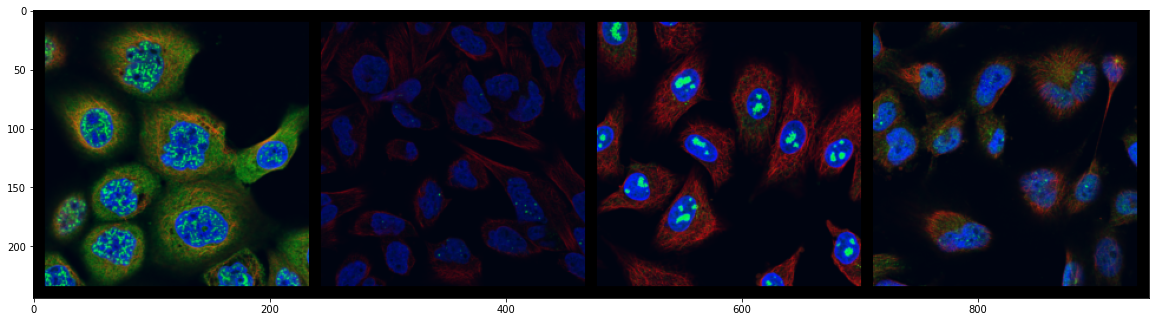

In [7]:
# example images visualization
data_loader,_ = dataloader(4)
data = next(iter(data_loader))

def show(img):
    npimg = img.numpy()
    plt.figure(figsize=(20, 50))
    plt.imshow(np.transpose(npimg, (1,2,0)))
    
show(utils.make_grid(data["images"], padding=10,normalize=True))

In [8]:
# load the efficient and change the output dimension to 19
model = EfficientNet.from_pretrained('efficientnet-b0')
feature = model._fc.in_features
# labels are 19 dimension
model._fc = nn.Linear(in_features=feature,out_features=19,bias=True)
model

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b0-355c32eb.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b0-355c32eb.pth


  0%|          | 0.00/20.4M [00:00<?, ?B/s]

Loaded pretrained weights for efficientnet-b0


EfficientNet(
  (_conv_stem): Conv2dStaticSamePadding(
    3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False
    (static_padding): ZeroPad2d(padding=(0, 1, 0, 1), value=0.0)
  )
  (_bn0): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dStaticSamePadding(
        32, 32, kernel_size=(3, 3), stride=[1, 1], groups=32, bias=False
        (static_padding): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
      )
      (_bn1): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
      (_se_reduce): Conv2dStaticSamePadding(
        32, 8, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_se_expand): Conv2dStaticSamePadding(
        8, 32, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_project_conv): Conv2dStaticSamePadding(
        32, 16, kernel_size=

In [9]:
# enable GPU for training
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DEVICE

device(type='cuda')

In [10]:
# training and validation functions
def loss_function(output, target):
    loss = nn.BCEWithLogitsLoss()
    result = loss(output, target)
    return result

def train_function(dataloader, model, optimizer):
    model.train()
    arr_output=[]
    arr_target=[]
    running_loss = []
    for data in tqdm(dataloader, total=len(dataloader)):
        images = data["images"].to(DEVICE)
        targets = data["labels"].to(DEVICE)
        optimizer.zero_grad()
        out = model(images)
        loss = loss_function(out, targets)
        loss.backward()
        optimizer.step()
        running_loss.append(loss.cpu().detach().numpy())
        outs = torch.sigmoid(out.cpu().detach())
        outs = np.round(outs.numpy())
        arr_output.extend(outs)
        arr_target.extend(targets.cpu().detach().numpy())
    f1 = f1_score(arr_target, arr_output, average="macro")
    acc = accuracy_score(arr_target, arr_output)
    pre = precision_score(arr_target, arr_output, average="macro")
    rec = recall_score(arr_target, arr_output, average="macro")
    return sum(running_loss)/len(dataloader), f1, acc, pre, rec

def val_function(dataloader, model):
    model.eval()
    arr_output=[]
    arr_target=[]
    running_loss = []
    with torch.no_grad():
        for data in tqdm(dataloader, total=len(dataloader)):
            images = data["images"].to(DEVICE)
            targets = data["labels"].to(DEVICE)
            out = model(images)
            loss = loss_function(out,targets)
            running_loss.append(loss.cpu().detach().numpy())
            outs = torch.sigmoid(out.cpu().detach())
            outs = np.round(outs.numpy())
            arr_output.extend(outs)
            arr_target.extend(targets.cpu().detach().numpy())
    f1 = f1_score(arr_target,arr_output, average="macro")
    acc = accuracy_score(arr_target, arr_output)
    pre = precision_score(arr_target, arr_output, average="macro")
    rec = recall_score(arr_target, arr_output, average="macro")
    return sum(running_loss)/len(dataloader), f1, acc, pre, rec


In [ ]:
# training process for the first time, 7 epochs completed
TRAINED_MODEL = "HPA_efficientnet"

def training(EPOCHS=15):
    train_dataloader, validation_dataloader = dataloader(batchsize=64) 
    model.to(DEVICE)
    optimizer = torch.optim.Adam(model.parameters()) 
    print("Training on GPU...")
    #best_loss = np.inf
    save_table = np.zeros(shape=(EPOCHS, 10))
    for e in range(EPOCHS):
        train_loss, train_f1, train_acc, train_pre, train_rec = train_function(train_dataloader, model, optimizer)
        val_loss, val_f1, val_acc, val_pre, val_rec = val_function(validation_dataloader, model)
        TRAINED_MODEL_FILE = TRAINED_MODEL + "_" + str(e+1) + "ep.pth"
        #if val_loss < best_loss:
        #    best_loss = val_loss
        #    print(f"model saved at {best_loss:.4f} loss")
        #torch.save(model.state_dict(), TRAINED_MODEL_FILE)
        torch.save({
            'epoch': e+1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_loss': train_loss,
            'val_loss': val_loss
            }, TRAINED_MODEL_FILE)
        print(f"Epoch:{e+1} | train: loss {train_loss:.5f} f1 {train_f1:.5f} accuracy {train_acc:.5f} precision {train_pre:.5f} recall {train_rec:.5f}")
        print(f"Epoch:{e+1} | val: loss {val_loss:.5f} f1 {val_f1:.5f} accuracy {val_acc:.5f} precision {val_pre:.5f} recall {val_rec:.5f}")
        save_table[e,:] = train_loss,train_f1,train_acc,train_pre,train_rec,val_loss,val_f1,val_acc,val_pre,val_rec
        np.savetxt(f"{TRAINED_MODEL}_{e+1}.txt",save_table,delimiter=",")        

In [ ]:
torch.cuda.empty_cache() 

In [ ]:
# training using 15 epochs
training(15) 
# this training only completed 7 epochs, below will continue from the 7 epochs checkpoint

In [11]:
model

EfficientNet(
  (_conv_stem): Conv2dStaticSamePadding(
    3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False
    (static_padding): ZeroPad2d(padding=(0, 1, 0, 1), value=0.0)
  )
  (_bn0): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dStaticSamePadding(
        32, 32, kernel_size=(3, 3), stride=[1, 1], groups=32, bias=False
        (static_padding): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
      )
      (_bn1): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
      (_se_reduce): Conv2dStaticSamePadding(
        32, 8, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_se_expand): Conv2dStaticSamePadding(
        8, 32, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_project_conv): Conv2dStaticSamePadding(
        32, 16, kernel_size=

In [12]:
DEVICE = torch.device('cuda')

weight = torch.load('/kaggle/input/efficientnet-rgb/efficientnet_rgb/HPA_efficientnet_7ep.pth', map_location=DEVICE)

In [13]:
# training process for the second time, starting from 8th epochs.
TRAINED_MODEL = "HPA_efficientnet"

def training2(EPOCHS=15):
    train_dataloader, validation_dataloader = dataloader(batchsize=64)
    model.load_state_dict(weight['model_state_dict']) # load previous 7 epochs model weights
    model.to(DEVICE)
    optimizer = torch.optim.Adam(model.parameters())
    optimizer.load_state_dict(weight['optimizer_state_dict']) # load previous 7 epochs optimizer
    print("Training on GPU...")
    #best_loss = np.inf
    save_table = np.zeros(shape=(EPOCHS, 10))
    for e in range(7, EPOCHS):
        train_loss, train_f1, train_acc, train_pre, train_rec = train_function(train_dataloader, model, optimizer)
        val_loss, val_f1, val_acc, val_pre, val_rec = val_function(validation_dataloader, model)
        TRAINED_MODEL_FILE = TRAINED_MODEL + "_" + str(e+1) + "ep.pth"
        #if val_loss < best_loss:
        #    best_loss = val_loss
        #    print(f"model saved at {best_loss:.4f} loss")
        #torch.save(model.state_dict(), TRAINED_MODEL_FILE)
        torch.save({
            'epoch': e+1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_loss': train_loss,
            'val_loss': val_loss
            }, TRAINED_MODEL_FILE)
        print(f"Epoch:{e+1} | train: loss {train_loss:.5f} f1 {train_f1:.5f} accuracy {train_acc:.5f} precision {train_pre:.5f} recall {train_rec:.5f}")
        print(f"Epoch:{e+1} | val: loss {val_loss:.5f} f1 {val_f1:.5f} accuracy {val_acc:.5f} precision {val_pre:.5f} recall {val_rec:.5f}")
        save_table[e,:] = train_loss,train_f1,train_acc,train_pre,train_rec,val_loss,val_f1,val_acc,val_pre,val_rec
        np.savetxt(f"{TRAINED_MODEL}_{e+1}.txt",save_table,delimiter=",")        

In [14]:
# second time training starting from 8th epochs
training2(15)

  0%|          | 0/256 [00:00<?, ?it/s]

Training on GPU...


100%|██████████| 256/256 [35:31<00:00,  8.32s/it]
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
100%|██████████| 86/86 [12:01<00:00,  8.39s/it]
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
  0%|          | 0/256 [00:00<?, ?it/s]

Epoch:8 | train: loss 0.08040 f1 0.75067 accuracy 0.62431 precision 0.82709 recall 0.69362
Epoch:8 | val: loss 0.10399 f1 0.65505 accuracy 0.50899 precision 0.88228 recall 0.56116


  0%|          | 0/256 [00:00<?, ?it/s]

Epoch:9 | train: loss 0.05322 f1 0.82441 accuracy 0.71628 precision 0.90051 recall 0.78008
Epoch:9 | val: loss 0.10201 f1 0.70900 accuracy 0.55337 precision 0.80672 recall 0.66970


  0%|          | 0/256 [00:00<?, ?it/s]

Epoch:10 | train: loss 0.04167 f1 0.85262 accuracy 0.76770 precision 0.91221 recall 0.81537
Epoch:10 | val: loss 0.10464 f1 0.69470 accuracy 0.54274 precision 0.76444 recall 0.66656


100%|██████████| 86/86 [11:55<00:00,  8.33s/it]
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
  0%|          | 0/256 [00:00<?, ?it/s]

Epoch:11 | train: loss 0.03297 f1 0.89015 accuracy 0.80836 precision 0.94931 recall 0.85577
Epoch:11 | val: loss 0.11869 f1 0.69743 accuracy 0.53870 precision 0.77659 recall 0.67445


  0%|          | 0/256 [00:00<?, ?it/s]

Epoch:12 | train: loss 0.03008 f1 0.90780 accuracy 0.82255 precision 0.94518 recall 0.87850
Epoch:12 | val: loss 0.14712 f1 0.68888 accuracy 0.48001 precision 0.76838 recall 0.65267


  0%|          | 0/256 [00:00<?, ?it/s]

Epoch:13 | train: loss 0.02696 f1 0.90428 accuracy 0.83967 precision 0.93598 recall 0.88040
Epoch:13 | val: loss 0.11937 f1 0.70784 accuracy 0.55649 precision 0.81496 recall 0.66477


  0%|          | 0/256 [00:00<?, ?it/s]

Epoch:14 | train: loss 0.02370 f1 0.92208 accuracy 0.85582 precision 0.95453 recall 0.89926
Epoch:14 | val: loss 0.14444 f1 0.69050 accuracy 0.51963 precision 0.84215 recall 0.62216


100%|██████████| 86/86 [12:02<00:00,  8.40s/it]


Epoch:15 | train: loss 0.02121 f1 0.93596 accuracy 0.87165 precision 0.95887 recall 0.91694
Epoch:15 | val: loss 0.14197 f1 0.69575 accuracy 0.52164 precision 0.83395 recall 0.64002
